In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

filepath = 'dataset'

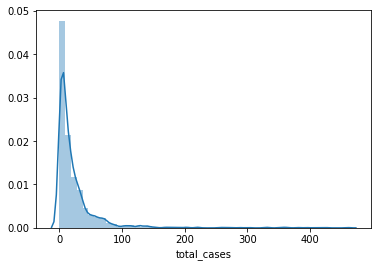

In [2]:
y = pd.read_csv(filepath + "/dengue_labels_train.csv")
sns.distplot(y.total_cases)
plt.show()

In [3]:
import statsmodels.api as sm

from warnings import filterwarnings

filterwarnings('ignore')

from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

/home/thejan/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
import numpy as np

from sklearn.model_selection import train_test_split
# from sklearn.feature_selection import RFE

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from scipy import stats

from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

In [7]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [8]:
def impute(X):
    
    # remove the colum that has ~20% null values, also ranks low on feature importance
    X.drop(['ndvi_ne'], axis=1, inplace=True)
    
    # Filling the rest using linear interpolation
    X.interpolate(inplace=True)


def remove_outliers(df):
    return df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]

def mape(Y_test, Y_pred, epsilon = 1):
    return np.mean(np.abs((Y_test - Y_pred + epsilon) / (Y_test + epsilon))) * 100

def extract_month(s):
    return int(s[5:7])

def city_indices(X):
    # city boolean encoding
    return X.city == 'sj'

def pre_process(X, y, trees = False):
    """
    Extracts the month out of date and converts it to a one hot
    Standardizes the numerical features
    """
    
    #Extracting month from the date
    months = X.week_start_date.apply(extract_month)
    
    #Response coding
#     month = X.week_start_date.apply(extract_month)
#     temp = pd.DataFrame(y.total_cases)
#     temp['month'] = month
#     for name,group in temp.groupby(month):
#         month[group.index] = np.median(group.total_cases)
        
    # Removing the columns not required for classification
    X.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)

    # Standardizing the data
    if not trees:
        scaler = StandardScaler()
        #X[X.columns] = scaler.fit_transform(X)

    # Month one hot features
    month_features = pd.get_dummies(months, prefix='m_')
    X = X.join(month_features)

    #Alternatively use response coding 
#     X = X.join(month)
    
    return X

In [9]:
def seperate_cities_data(X, is_sj):

    # Seperating the cities data
    X_sj = X.loc[is_sj]
    X_iq = X.loc[~is_sj]
    
    return X_sj, X_iq

def get_y_labels(X_sj, X_iq, y):    
    
    y = y.total_cases    
    y_sj = y.loc[X_sj.index]
    y_iq = y.loc[X_iq.index]
    
    return y_sj, y_iq

def split(X_sj, X_iq, y_sj, y_iq):

    # train and test split
    sj_split_data = train_test_split(X_sj, y_sj, shuffle = False)
    iq_split_data = train_test_split(X_iq, y_iq, shuffle = False)
    return sj_split_data, iq_split_data

def process(X, y = pd.Series(), train = True, trees = False, feature_selection = 0, time_shift = 0):
    
    is_sj = city_indices(X)
    if not trees:
        impute(X)
    X = pre_process(X, y, trees)
    
    if feature_selection:
        selector = SelectKBest(f_regression, k=feature_selection).fit(X,y.total_cases)
        X = X.loc[:,selector.get_support()]

    X = remove_outliers(X)
    X_sj, X_iq = seperate_cities_data(X, is_sj)

    if y.empty:
        return X_sj, X_iq
    
    y_sj, y_iq = get_y_labels(X_sj, X_iq, y)
    if time_shift:
        y_sj = y_sj.shift(time_shift).dropna()
        y_iq = y_iq.shift(time_shift).dropna()
        X_sj = X_sj[:-time_shift]
        X_iq = X_iq[:-time_shift]
        
    if not train:
        return X_sj, X_iq, y_sj, y_iq
    
    return split(X_sj, X_iq, y_sj, y_iq)

In [10]:
def testProcess(X, y = pd.Series(), train = True, trees = False, feature_selection = 0, time_shift = 0):
    
    is_sj = city_indices(X)
    if not trees:
        impute(X)
    X = pre_process(X, y, trees)
    
   

    #X = remove_outliers(X)
    X_sj, X_iq = seperate_cities_data(X, is_sj)
    
    return X_sj, X_iq

In [11]:
X = pd.read_csv(filepath+"/dengue_features_train.csv")
data = process(X,y)


(X_sj_train, X_sj_test, Y_sj_train, Y_sj_test), (X_iq_train, X_iq_test, Y_iq_train, Y_iq_test) = data



In [12]:
formula = ' + '.join([str(i) for i in list(X_sj_train.columns)])
formula = 'y ~ ' + formula
print formula

y ~ ndvi_nw + ndvi_se + ndvi_sw + precipitation_amt_mm + reanalysis_air_temp_k + reanalysis_avg_temp_k + reanalysis_dew_point_temp_k + reanalysis_max_air_temp_k + reanalysis_min_air_temp_k + reanalysis_precip_amt_kg_per_m2 + reanalysis_relative_humidity_percent + reanalysis_sat_precip_amt_mm + reanalysis_specific_humidity_g_per_kg + reanalysis_tdtr_k + station_avg_temp_c + station_diur_temp_rng_c + station_max_temp_c + station_min_temp_c + station_precip_mm + m__1 + m__2 + m__3 + m__4 + m__5 + m__6 + m__7 + m__8 + m__9 + m__10 + m__11 + m__12


In [13]:
train_sj = X_sj_train.copy()
train_sj['y'] = Y_sj_train
print train_sj

      ndvi_nw   ndvi_se   ndvi_sw  precipitation_amt_mm  \
0    0.103725  0.198483  0.177617                 12.42   
1    0.142175  0.162357  0.155486                 22.82   
2    0.172967  0.157200  0.170843                 34.54   
3    0.245067  0.227557  0.235886                 15.36   
4    0.262200  0.251200  0.247340                  7.52   
5    0.174850  0.254314  0.181743                  9.58   
6    0.092800  0.205071  0.210271                  3.48   
7    0.072500  0.151471  0.133029                151.12   
8    0.146175  0.125571  0.123600                 19.32   
9    0.121550  0.160683  0.202567                 14.41   
10   0.082350  0.191943  0.152929                 22.27   
11   0.211800  0.301200  0.280667                 59.17   
12   0.171700  0.226900  0.214557                 16.48   
13   0.247150  0.379700  0.381357                 32.66   
14   0.064333  0.164443  0.138857                 28.80   
15   0.128033  0.206957  0.168243                 90.75 

In [14]:
test_sj = X_sj_test.copy()

model = smf.glm(formula=formula,
                data=train_sj,
                family=sm.families.NegativeBinomial())
model = model.fit()

predictions_sj = model.predict(test_sj).astype(int)
print ("cv error:", mean_absolute_error(predictions_sj, Y_sj_test))

pred_train_sj = model.predict(train_sj).astype(int)
print ("train error:", mean_absolute_error(pred_train_sj, Y_sj_train))

('cv error:', 23.214592274678111)
('train error:', 25.572453371592541)


In [15]:
X2 = pd.read_csv(filepath+"/dengue_features_test.csv")
testSJ,testIQ = testProcess(X2,y)

In [16]:
print(testSJ.shape)

(260, 31)


In [17]:
predictions_sj_test = model.predict(testSJ).astype(int)
predictions_sj_test = predictions_sj_test-2

In [18]:

predictions_sj_test.to_csv(filepath+'/resultSJ.csv',  index = False)

In [19]:
train_iq = X_iq_train.copy()
train_iq['y'] = Y_iq_train
test_iq = X_iq_test.copy()

modelIQ = smf.glm(formula=formula,
                data=train_iq,
                family=sm.families.NegativeBinomial())
modelIQ = modelIQ.fit()

predictions_iq = modelIQ.predict(test_iq).astype(int)
print ("cv error:", mean_absolute_error(predictions_iq, Y_iq_test))

pred_train_iq = modelIQ.predict(train_iq).astype(int)
print ("train error:", mean_absolute_error(pred_train_iq, Y_iq_train))

('cv error:', 8.0546875)
('train error:', 5.4778067885117494)


In [20]:
predictions_iq_test = modelIQ.predict(testIQ).astype(int)
predictions_iq_test = predictions_iq_test-1
print(predictions_iq_test)
predictions_iq_test.to_csv(filepath+'/resultIQ.csv',  index = False)

260     3
261     2
262     9
263     3
264     1
265     1
266     1
267     1
268     1
269     3
270     5
271     3
272     1
273     2
274     0
275     3
276     1
277    11
278    10
279     2
280     2
281    10
282    17
283    10
284    10
285     5
286     3
287     5
288     5
289     8
       ..
386    27
387    18
388    19
389    29
390    15
391     3
392     6
393    10
394     6
395    10
396     4
397     8
398     8
399     8
400     8
401    13
402     6
403     3
404     4
405     6
406     8
407     1
408     6
409     5
410     2
411     5
412     5
413     3
414     0
415     1
Length: 156, dtype: int64


In [21]:
# submission
submission_format = pd.read_csv(filepath+'/submission_format.csv')
total_preds = list(predictions_sj_test) + list(predictions_iq_test)
submission_format['total_cases'] = total_preds

submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))
submission_format.to_csv(filepath+'/by_model1_27_1_05_18v2.csv', index=False)

In [22]:
pred = predictions_iq.append(predictions_sj)
true = Y_iq_test.append(Y_sj_test)
print ("cv error:", mean_absolute_error(pred, true))

train_pred = pred_train_iq.append(pred_train_sj)
train_true = Y_iq_train.append(Y_sj_train)
print ("train error:", mean_absolute_error(train_pred, train_true))

('cv error:', 17.8393351800554)
('train error:', 18.446296296296296)
